In [1]:
import pandas as pd 
import numpy as np 

from tqdm.auto import tqdm 

import torch 
import torch.nn as nn 
from torch.utils.data import Dataset, DataLoader 

from transformers import BertTokenizerFast as BertTokenizer, BertModel, AdamW, get_linear_schedule_with_warmup

import pytorch_lightning as pl 
from torchmetrics.functional import accuracy, f1, auroc
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from pytorch_lightning.loggers import TensorBoardLogger

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, multilabel_confusion_matrix

import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc

C:\Users\pcapp\anaconda3\lib\site-packages\torchvision\io\image.py:11: UserWarning: Failed to load image Python extension: Could not find module 'C:\Users\pcapp\anaconda3\Lib\site-packages\torchvision\image.pyd' (or one of its dependencies). Try using the full path with constructor syntax.
  warn(f"Failed to load image Python extension: {e}")


In [2]:
RANDOM_SEED = 42 
torch.manual_seed(RANDOM_SEED)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [4]:
df = pd.read_csv('training-data-positive-and-negative-sentiment-english.csv')
df = df.drop('Unnamed: 0',axis=1)
df.head()

,Date,text,Sentiment
0,2019-05-27,È appena uscito un nuovo video! LES CRYPTOMONN...,Positive
1,2019-05-27,Cardano: Digitize Currencies; EOS https://t.co...,Positive
2,2019-05-27,Another Test tweet that wasn't caught in the s...,Positive
3,2019-05-27,Current Crypto Prices! \n\nBTC: $8721.99 USD\n...,Positive
4,2019-05-27,Spiv (Nosar Baz): BITCOIN Is An Asset &amp; NO...,Positive


Text(0.5, 0, 'Sentiment Score')

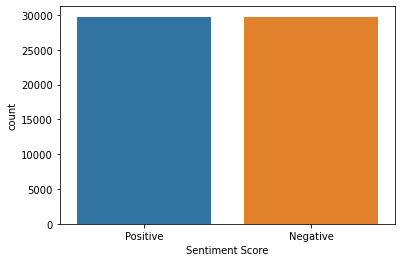

In [5]:
sns.countplot(x=df.Sentiment)
plt.xlabel('Sentiment Score')

In [10]:
# since there are no neutral tweets in our training data, we got some from Kaggle 
df1 = pd.read_csv('bitcointweets.csv')
df1.head()

,Fri Mar 23 00:40:32 +0000 2018,text,myresumerocket,16522,0,[],"<a href=""http://twitter.com"" rel=""nofollow"">Twitter Web Client</a>",Sentiment
0,Fri Mar 23 00:40:34 +0000 2018,@lopp @_Kevin_Pham @psycho_sage @naval But @Pr...,BitMocro,1295,0,[u'Bitcoin'],"<a href=""http://twitter.com/download/android"" ...",['neutral']
1,Fri Mar 23 00:40:35 +0000 2018,RT @tippereconomy: Another use case for #block...,hojachotopur,6090,0,"[u'blockchain', u'Tipper', u'TipperEconomy']","<a href=""http://twitter.com"" rel=""nofollow"">Tw...",['positive']
2,Fri Mar 23 00:40:36 +0000 2018,free coins https://t.co/DiuoePJdap,denies_distro,2626,0,[],"<a href=""http://twitter.com"" rel=""nofollow"">Tw...",['positive']
3,Fri Mar 23 00:40:36 +0000 2018,RT @payvxofficial: WE are happy to announce th...,aditzgraha,184,0,[],"<a href=""http://twitter.com/download/android"" ...",['positive']
4,Fri Mar 23 00:40:36 +0000 2018,Copy successful traders automatically with Bit...,VictorS61164810,14,0,[],"<a href=""http://twitter.com"" rel=""nofollow"">Tw...",['positive']


In [11]:
df1 = df1.iloc[:,[1,7]]
df1 = df1.loc[df1["Sentiment"]=="['neutral']"]
df1.reset_index(drop=True)

,text,Sentiment
0,@lopp @_Kevin_Pham @psycho_sage @naval But @Pr...,['neutral']
1,One click to start mining cryptocurrencies tog...,['neutral']
2,RT @livemarketcap: ICE Agency Charges Payza an...,['neutral']
3,RT @Vaultoro: We have all seen the HTTP protoc...,['neutral']
4,@eatBCH @Bitcoin @signalapp @myWickr @Samsung ...,['neutral']
...,...,...
21933,Bitcoin: Mastering Bitcoin: Discover How I (An...,['neutral']
21934,"#Zhao #Dong #Recounts How He Lost 9,000 #BTC h...",['neutral']
21935,Bitcoin Price Technical Analysis for 03/23/201...,['neutral']
21936,"RT @PhotoCoin_io: 2,000,000 PHT TOKEN #airdrop...",['neutral']


In [12]:
for index, row in df1.iterrows(): 
    if row['Sentiment']=="['neutral']":
        row['Sentiment']='neutral'

In [13]:
df1.tail()

,text,Sentiment
50845,Bitcoin: Mastering Bitcoin: Discover How I (An...,neutral
50847,"#Zhao #Dong #Recounts How He Lost 9,000 #BTC h...",neutral
50850,Bitcoin Price Technical Analysis for 03/23/201...,neutral
50852,"RT @PhotoCoin_io: 2,000,000 PHT TOKEN #airdrop...",neutral
50855,"RT @GymRewards: Buy #GYMRewards Tokens, Bonus ...",neutral
